In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import random

# Concernant les couleurs

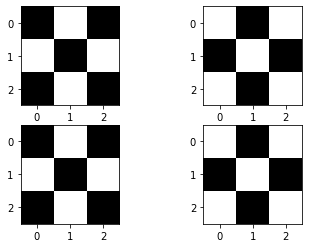

In [79]:
matrix_color = [np.array([[0,1,0],[1,0,1],[0,1,0]]),
                np.array([[1,0,1],[0,1,0],[1,0,1]]),
                np.array([[0,255,0],[255,0,255],[0,255,0]]),
                np.array([[255,0,255],[0,255,0],[255,0,255]])]
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(matrix_color[0], cmap = "gray") 
axs[0,1].imshow(matrix_color[1], cmap = "gray")
axs[1,0].imshow(matrix_color[2], cmap = "gray")
axs[1,1].imshow(matrix_color[3], cmap = "gray")
plt.show()

**Donc, il semble que**
* 0 = noir
* 1 (si 0/1) ou 255 (si 0/255) = blanc

# Fonctions

## Fonctions liées à l'ajout de gris à une image

In [2]:
def tograyscale(mat):
    """
    Scale les nombres de la matrice dans [0,255] (pour permettre les images en nuance de gris)
    Mais ne prend pas encore en compte le négatif
    """
    scaled_mat = 255.0 * mat / mat.max()
    #scaled_mat[scaled_mat<0] = 0 ?
    return scaled_mat

In [3]:
def to_binary(filename):
    """
    Importation de l'image, passage en nuance de gris, puis passage dans {0,1}
    """
    my_img = Image.open(filename)
    img_gray = ImageOps.grayscale(my_img) # Conversion en nuances de gris
    img_gray = np.array(img_gray)
    img_gray_binary = np.where(img_gray > 0.5, 1, 0) #Passage en binaire (méthodologie douteuse)
    return img_gray_binary


In [4]:
def noise(img, TAU, MU):
    """
    Ajout d'un bruit gaussien aux pixels de l'image
    """
    img_noised = np.zeros(shape = img.shape)
    row, col = np.shape(img)
    for i in range(row):
        for j in range(col):
            # ATTENTION: scale c'est l'écart type et pas la variance !
            img_noised[i,j] = np.random.normal(loc = MU[int(img[i,j])], scale = TAU)
    
    return img_noised

In [137]:
def create_noised_image(img, name, TAU, MU = [0,1]):
    """
    img = chemin vers l'image à bruiter
    name = suffixe de l'image bruitée enregistrée
    TAU = écart-type pour le bruit gaussien
    MU = moyenne pour le bruit gaussien MU[0] = 0, MU[1] = 1 par défaut donc bruit centré
    Pour faire un autre bruit MU[0] correspond au biais des pixels valant 0 dans l'image d'origine
    MU[1] correspond au biais valant 1 dans l'image d'origine
    """
    
    img_bin = to_binary(img) # Vu que l'image originale doit être dans [0,1], on force les pixels à ne valoir qu'une 
    # seule de ces valeurs
    img_bin_noised = noise(img_bin, TAU, MU)
    plt.imshow(img_bin_noised, cmap = "gray")
    
    tosave = Image.fromarray(tograyscale(img_bin_noised))
    tosave.convert("L").save("data/"+str(name)+"_TAU="+str(TAU)+".png")
    tosave.convert("L").save("data/"+str(name)+"_TAU="+str(TAU)+
                             "_MU="+str(MU[0])+"_"+str(MU[1])+".png")

## Fonctions liées au gibbs sampling à propos parlé

In [6]:
def sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU):
    """
    Echantillonne dans la distribution conditionnelle pour un pixel
    """
   
    # Ajout des valeurs des 4 voisins du pixel considéré, si pertinent
    voisins = []
    if i != 0:
        voisins.append(X[i-1][j])
    if i!= maxi-1:
        voisins.append(X[i+1][j])
    if j!= 0:
        voisins.append(X[i][j-1])
    if j!= maxj-1:
        voisins.append(X[i][j+1])
        
    # Calcul du nombre de 0 et de 1 dans les voisins
    nb_0 = sum(voisins[i] == 0 for i in range(len(voisins)))
    nb_1 = sum(voisins[i] == 1 for i in range(len(voisins)))
    
    # Prise en considération de la variation du nombre de voisins (bords)
    pond = 4/len(voisins) 
    
    # Calcul de la probabilité de valoir 1
    exp_valeur_1 = -ALPHA + BETA * pond * (nb_0-nb_1) + 1/(2*(TAU**2))*(MU[1]**2 - MU[0]**2 + 2*Y[i][j]*(MU[0]-MU[1]))
    
    # Calcul de la probabilité de valoir 0 (juste pour vérifier)
    #exp_valeur_0 = ALPHA + BETA * pond * (nb_1-nb_0) + 1/(2*(TAU**2))*(MU[0]**2 - MU[1]**2 + 2*Y[i][j]*(MU[1]-MU[0]))
    #print(1/(1+np.exp(exp_valeur_1)) + 1/(1+np.exp(exp_valeur_0)))
    #print(1/(1+np.exp(exp_valeur_0)))
    
    prob = 1/(1+np.exp(exp_valeur_1))
    
    # Renvoie 1 si l'uniforme est inférieure à la proba de valoir 1
    U = np.random.rand()
    return(int(U < prob)) 

In [70]:
def get_posterior(filename, burn_in, samples, ALPHA, BETA, TAU, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 # Puisque le bruitage a été fait dans [0,1], le débruitage doit l'être aussi
    
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    X_prior = X.copy() # Sauvegarde pour l'affichage plus bas
    
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                        
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
            
            
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On fait la moyenne
    posterior = posterior / samples
    
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(Y, cmap = "gray") 
    axs[0].set_title("Image bruitée")
    axs[1].imshow(X_prior, cmap = "gray")
    axs[1].set_title("Prior aléatoire")
    axs[2].imshow(posterior, cmap = "gray")
    axs[2].set_title("Posterior")
    plt.show()

    return posterior

In [87]:
def posterior_to_binary(posterior, seuil):
    """
    Transforme notre posterior en nuances de gris en un posterior en noir et blanc
    Tout pixel valant 1 a une fréquence supérieure au seuil est considéré comme valant 1
    """
    
    if seuil < 0 or seuil > 1.0:
        print("Erreur: le seuil choisi ne correspond pas à une fréquence")
        return False 
    
    # On remplit l'image de blanc
    posterior_nb = np.ones(posterior.shape, dtype = np.float64)
    
    # On met des pixels noirs là où ils sont très peu souvent blancs
    # Comme on relève la fréquence des pixels blancs, il faut qu'on soit inférieur à un seuil
    # Cad qu'on met noirs les pixels très peu souvent blancs
    posterior_nb[posterior < seuil] = 0
    plt.imshow(posterior_nb, cmap = "gray")
    plt.show()
    
    return posterior_nb

# Tests

In [ ]:
I = 2
J = 2
pairs = []

for i in range(I):
    for j in range(J):
        pairs.append((i,j))
random.shuffle(pairs)
pairs

# Bruitage d'une image

**Bien se rappeler que tau correspond à l'écart-type et non pas à la variance !!**
Le nom de l'image contient la valeur de tau et les valeurs de mu

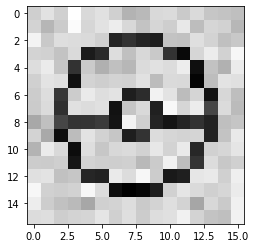

In [19]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1)

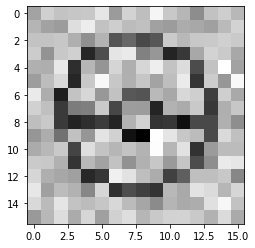

In [22]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.2)

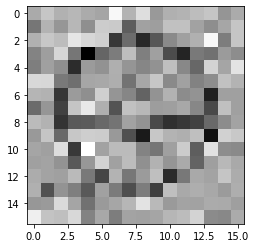

In [23]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.4)

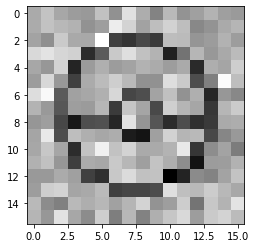

In [140]:
create_noised_image("data/poke.png", "poke_noise", TAU = 0.1, MU = [0.5, 1])

# Exemple d'affichage d'une image

In [ ]:
og_image = Image.open("data/poke_noise_01_0point1.png")
plt.imshow(og_image, cmap = "gray")
og_array = np.array(og_image)
print(og_array)
og_bis = np.ones(shape = og_array.shape)
og_bis[og_array<1] = 0
plt.imshow(og_bis, cmap = "gray")
og_image.close()

# Tentative de débruitage

Avec un écart-type de 0.1, on arrive à débruiter en une seule étape

100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


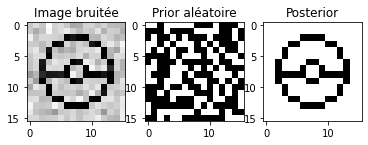

In [71]:
posterior = get_posterior("data/poke_noise_TAU=0.1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)

Avec un écart type plus élevé, ça se complique 

100%|██████████| 110/110 [00:03<00:00, 35.79it/s]


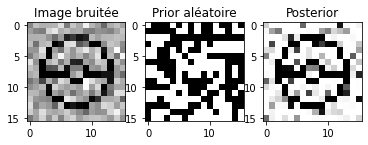

In [74]:
posterior = get_posterior("data/poke_noise_TAU=0.2.png", 10, 100, ALPHA = 0.01, BETA = 0.01, TAU = 0.2, 
                          deter = False)

Mais en filtrant les probas selon un seuil, on peut quand même retrouver l'image de base ! 
Ici, les pixels noirs sont les pixels qui ne sont pas blancs 99% du temps

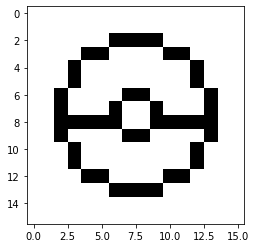

In [90]:
post_nb = posterior_to_binary(posterior, seuil = 0.01)

Pour un écart-type de 0.4, ca se complique encore. J'arrive à l'image générale mais pas exacte

100%|██████████| 11000/11000 [03:54<00:00, 46.84it/s]


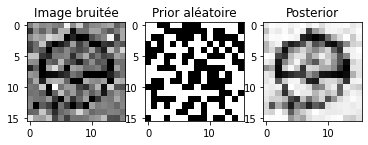

In [114]:
posterior = get_posterior("data/poke_noise_TAU=0.4.png", 10000, 1000, ALPHA = 1.0, BETA = 0.6, TAU = 0.4, 
                          deter = False)

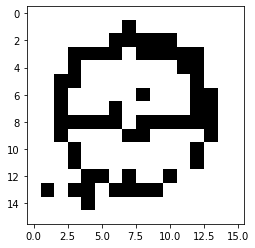

In [117]:
post_nb = posterior_to_binary(posterior, seuil = 0.5)

Essaie sur des images avec un biais

Avec des biais faibles peu de problèmes

100%|██████████| 2000/2000 [00:51<00:00, 38.54it/s]


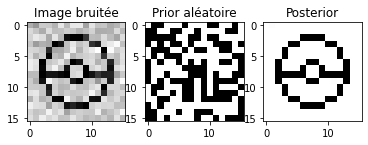

In [134]:
posterior = get_posterior("data/poke_noise_TAU=0.1_MU0.1_1.png", 1000, 1000, ALPHA = 0.1, 
                          BETA = 0.1, TAU = 0.1, MU = [0.1, 1],
                          deter = True)

100%|██████████| 2000/2000 [00:38<00:00, 52.43it/s]


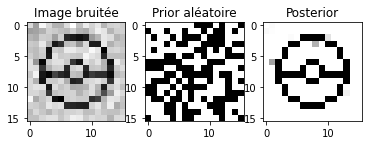

In [139]:
posterior = get_posterior("data/poke_noise_TAU=0.1_MU0.2_1.png", 1000, 1000, ALPHA = 0.1, 
                          BETA = 0.1, TAU = 0.1, MU = [0.2, 1],
                          deter = True)

Avec des biais plus élevés, ca se complique

100%|██████████| 2000/2000 [00:45<00:00, 44.01it/s]


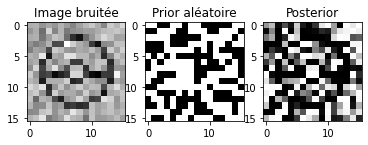

In [141]:
posterior = get_posterior("data/poke_noise_TAU=0.1_MU0.5_1.png", 1000, 1000, ALPHA = 0.1, 
                          BETA = 0.1, TAU = 0.1, MU = [0.5, 1],
                          deter = True)